Just going to use `chb01_03.edf` initially as it contains a seizure.

In [2]:
import mne

raw = mne.io.read_raw_edf("chb01_03.edf")
raw.load_data()

Extracting EDF parameters from /home/angus/Insync/angus.logan@baronsview.com/Google Drive/@1Uni/work/year4/cs408/cs408-python/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


/tmp/ipykernel_9258/4270159586.py:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf("chb01_03.edf")


<RawEDF | chb01_03.edf, 23 x 921600 (3600.0 s), ~161.7 MB, data loaded>

Effective window size : 8.000 (s)


/home/angus/Insync/angus.logan@baronsview.com/Google Drive/@1Uni/work/year4/cs408/cs408-python/venv/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


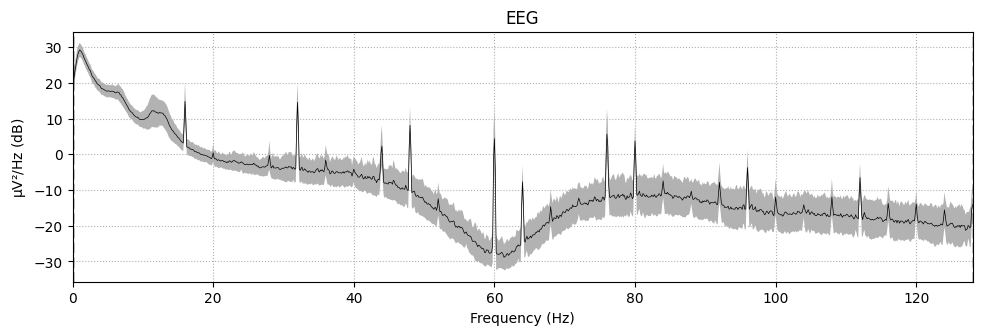

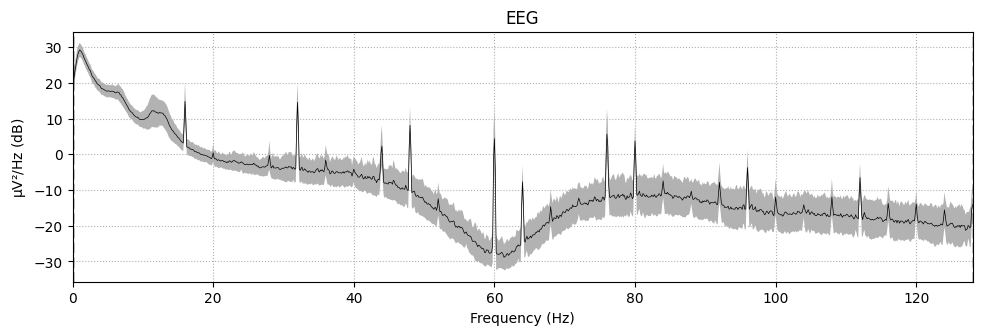

In [3]:
spectrum = raw.compute_psd()
spectrum.plot(average=True)

The peak at 60Hz is caused by the power line interference, as the data was recorded at the Boston Children's Hospital in America (where the grid runs at 60Hz). The peak at 120Hz is also caused by this, as it's the second harmonic of the grid.

The other peaks, especially those around the 30Hz mark could be related to the heartbeat of the patient, however I'm not sure if these can be properly identified without gradiometers or magnetometers.

I'm going to apply a bandpass filter to remove frequencies below 0.5Hz and above 34Hz (both figures found in lit review). This will remove any low  and high frequency noise from the data - "most brain activity occurs between 3 and 29Hz".

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 34 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 34.00 Hz
- Upper transition bandwidth: 8.50 Hz (-6 dB cutoff frequency: 38.25 Hz)
- Filter length: 1691 samples (6.605 s)

Effective window size : 8.000 (s)


/home/angus/Insync/angus.logan@baronsview.com/Google Drive/@1Uni/work/year4/cs408/cs408-python/venv/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


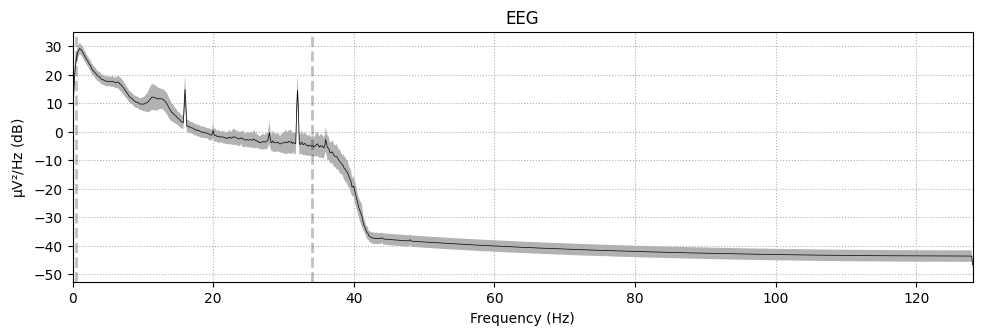

In [5]:
# perform a notch filter for the power line interference and the second harmonic
filtered = raw.copy().filter(l_freq=0.5, h_freq=34)
spectrum = filtered.compute_psd()
spectrum.plot(average=True)

Next I'll apply ICA to try and repair artefacts.

In [4]:
from mne.preprocessing.ica import ICA

ica = ICA(n_components=10, max_iter="auto")
ica.fit(filtered)

NameError: name 'filtered' is not defined

Creating RawArray with float64 data, n_channels=10, n_times=921600
    Range : 0 ... 921599 =      0.000 ...  3599.996 secs
Ready.


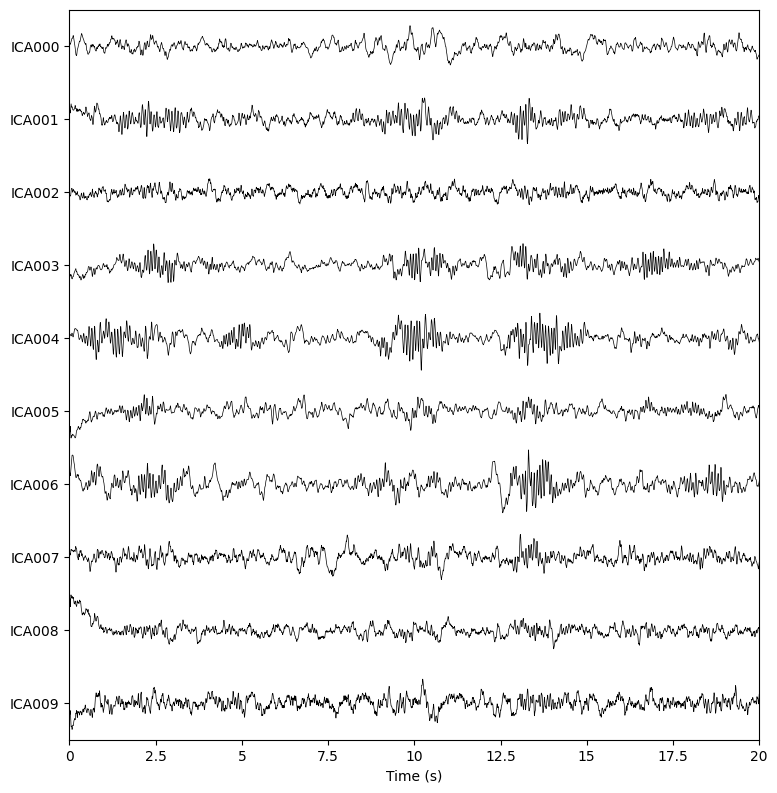

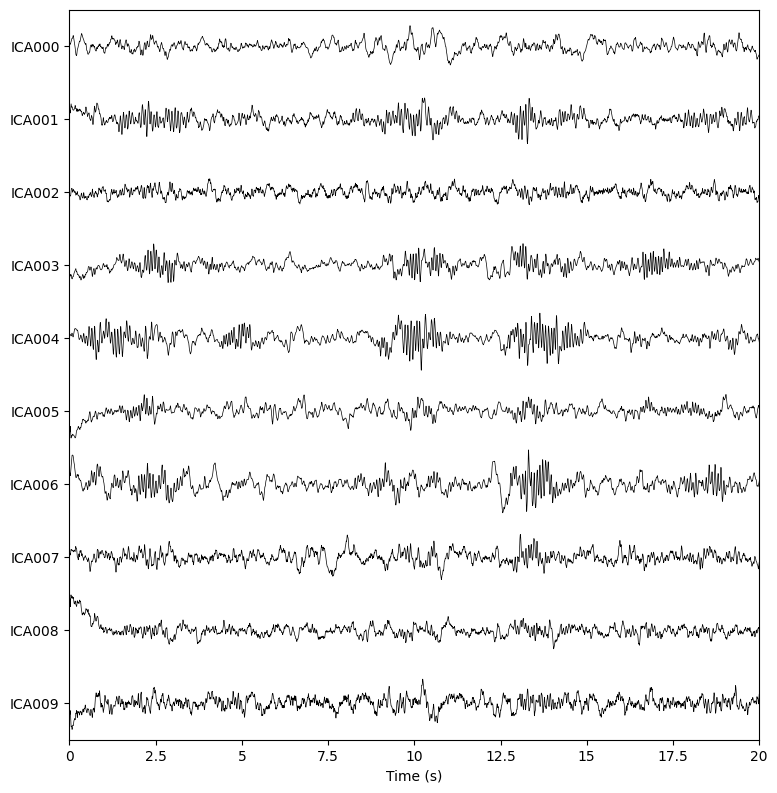

In [23]:
ica.plot_sources(filtered, show_scrollbars=False)

Applying ICA to Raw instance


    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 23 PCA components
Using matplotlib as 2D backend.


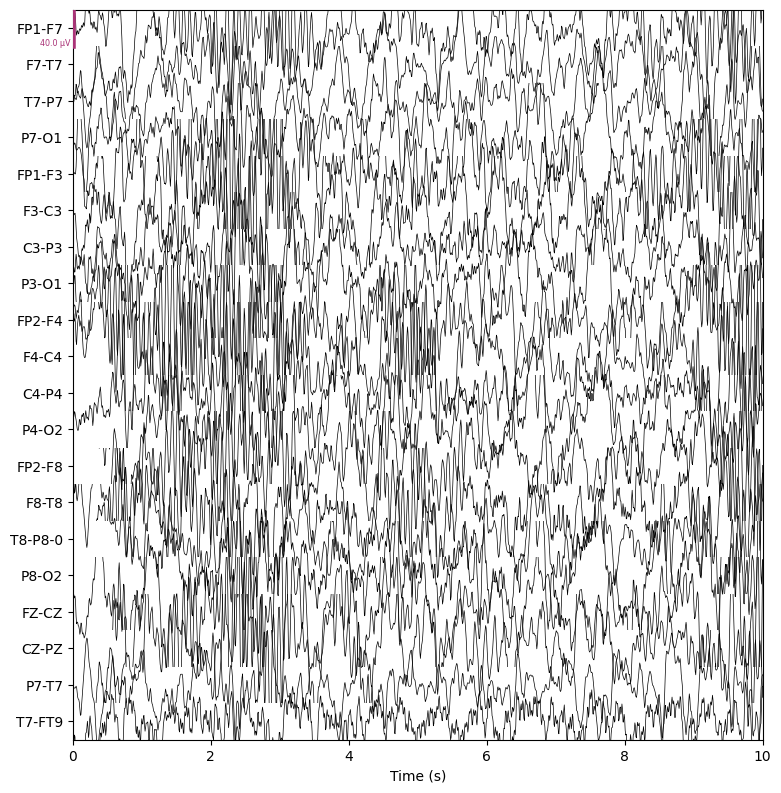

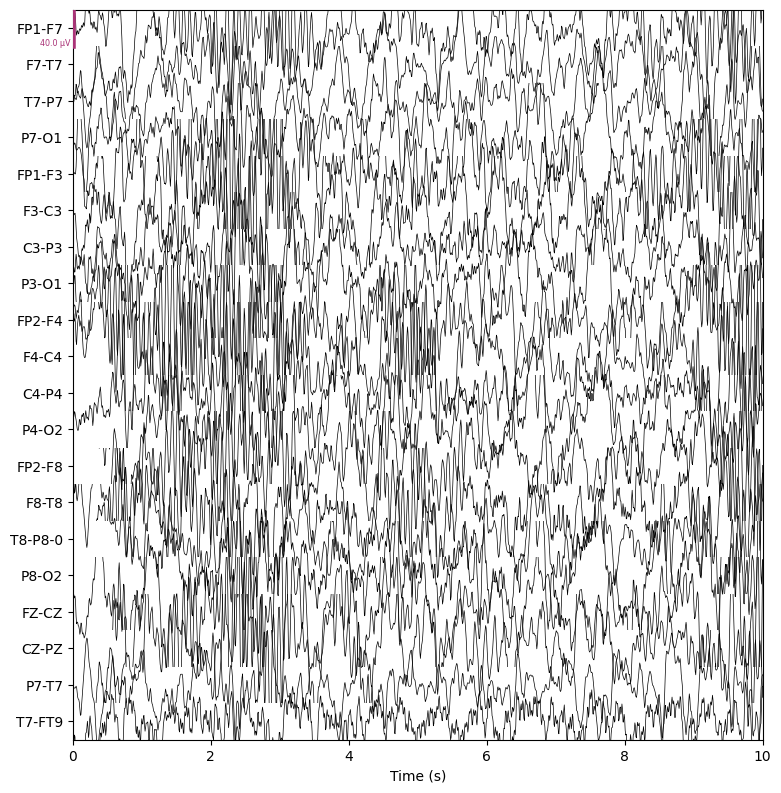

In [7]:
filtered_ica = filtered.copy()
ica.apply(filtered_ica)

filtered_ica.plot(show_scrollbars=False, title="EEG Data after Highpass and ICA Repair")

Effective window size : 8.000 (s)


c:\Users\angus\Documents\cs408-eeg-python\venv\Lib\site-packages\mne\viz\utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


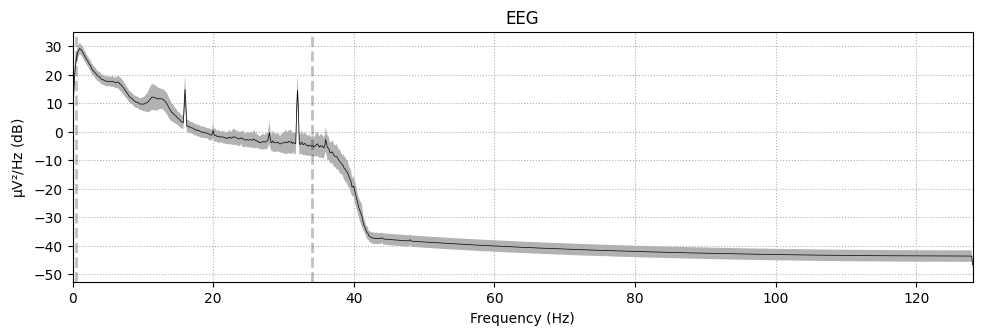

In [9]:
ica_psd = filtered_ica.compute_psd()
ica_psd.plot(average=True)

Effective window size : 8.000 (s)


c:\Users\angus\Documents\cs408-eeg-python\venv\Lib\site-packages\mne\viz\utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


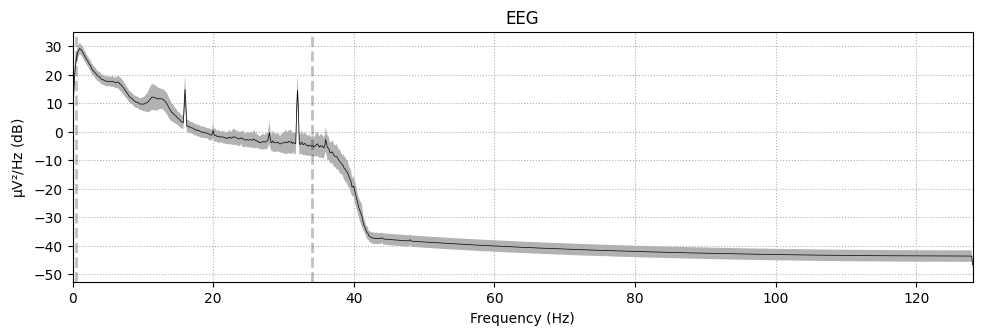

In [10]:
filtered_psd = filtered.compute_psd()
filtered_psd.plot(average=True)

I can't see much if any difference between the ICA and non-ICA PSD graphs. I'm not sure if the ICA actually did anything. Visually comparing the pre and post ICA EEG data also doesn't show much, if any, difference either.

In [19]:
# filtered.export("preprocessing-samples/filtered.edf")
filtered_ica.export("preprocessing-samples/ica-10.edf")

Applying ICA to Raw instance
    Transforming to ICA space (22 components)
    Zeroing out 0 ICA components
    Projecting back using 23 PCA components


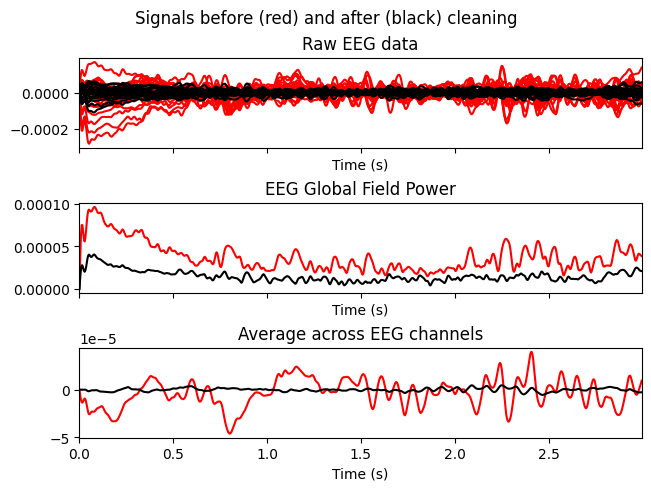

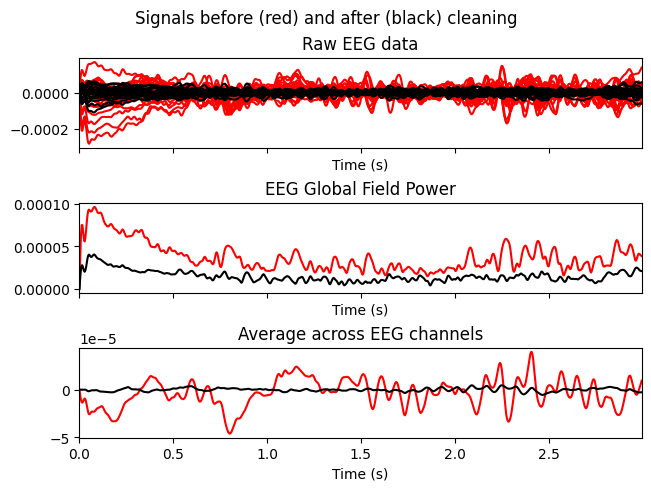

In [27]:
ica.plot_overlay(filtered)

In [8]:
import numpy as np
epochs = mne.make_fixed_length_epochs(filtered_ica, duration=1, overlap=0.96)
print("done")
epochs_np_array = epochs.get_data()
# print(epochs_np_array.shape)

Not setting metadata
89976 matching events found
No baseline correction applied
0 projection items activated
done
Using data from preloaded Raw for 89976 events and 256 original time points ...
0 bad epochs dropped


In [9]:
np.save("chb01-03_epochs_np_array", epochs_np_array)